In [1]:
!pip install opendatasets #to easily download datasets from kaggle

Imports

In [2]:
import os 
import opendatasets as od
import requests
from zipfile import ZipFile
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from PIL import Image
from PIL import ImageOps
import re
import tensorflow as tf
from tensorflow.keras import layers, models

Helper functions

In [3]:
LangSamples = 1000
SquareSide = 32

def load_img(file_name, prefix, invert=False): 
    img = Image.open(prefix + file_name).convert('L').resize((SquareSide, SquareSide))
    if invert:
        img = ImageOps.invert(img)
    return pd.Series(np.array(img.getdata()), dtype='uint8')

Download original datasets

In [4]:
od.download("https://www.kaggle.com/datasets/mloey1/ahcd1?resource=download")
od.download("https://www.kaggle.com/datasets/dhruvildave/english-handwritten-characters-dataset")
od.download("https://www.kaggle.com/datasets/lynnporu/rukopys")
r = requests.get("https://github.com/inoueMashuu/hiragana-dataset/archive/refs/heads/master.zip")
if not os.path.exists('hiragana-dataset-master'):    
    with open('master.zip', 'wb') as f:
        f.write(r.content)
    with ZipFile('master.zip', 'r') as zip:
        zip.extractall()
    print("Hiragana dataset successfully downloaded")
else:
    print("Skipping, hiragana dataset already downloaded")
if os.path.exists('master.zip'):        
    os.remove('master.zip')    

Skipping, found downloaded files in "./ahcd1" (use force=True to force download)
Skipping, found downloaded files in "./english-handwritten-characters-dataset" (use force=True to force download)
Skipping, found downloaded files in "./rukopys" (use force=True to force download)
Skipping, hiragana dataset already downloaded


Preprocess datasets and then combine them

In [5]:
# ARABIC
arabic_df = pd.read_csv('ahcd1/csvTrainImages 13440x1024.csv', header=None, dtype='uint8')
arabic_labels = pd.read_csv('./ahcd1/csvTrainLabel 13440x1.csv', names=['label'])
# use train_test_split to take 1000 datapoints in a stratified way 
arabic_df, _ = train_test_split(arabic_df, train_size=LangSamples,
                                                 random_state=42, stratify=arabic_labels)
arabic_df.reset_index(inplace=True, drop=True)
arabic_df['label'] = np.uint8(0)
arabic_df.head(5)

,0,1,2,3,4,5,6,7,8,9,...,1015,1016,1017,1018,1019,1020,1021,1022,1023,label
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
# LATIN (ENGLISH)
latin_df = pd.read_csv('english-handwritten-characters-dataset/english.csv')
latin_df, _ = train_test_split(latin_df, train_size=LangSamples, random_state=42,
                                                  stratify=latin_df['label'])
latin_df.reset_index(drop=True, inplace=True)
latin_df = latin_df['image'].apply(
    lambda filename: load_img(filename, 'english-handwritten-characters-dataset/', invert=True) )
latin_df['label'] = np.uint8(1)
latin_df.head(5)

,0,1,2,3,4,5,6,7,8,9,...,1015,1016,1017,1018,1019,1020,1021,1022,1023,label
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [7]:
# CYRILLIC (UKRANIAN)
cyrillic_df = pd.read_csv('rukopys/glyphs.csv')
cyrillic_df, _ = train_test_split(cyrillic_df, train_size=LangSamples, random_state=42,
                                                  stratify=cyrillic_df['label'])
cyrillic_df.reset_index(drop=True, inplace=True)
cyrillic_df = cyrillic_df['filename'].apply(
    lambda filename: load_img(filename, 'rukopys/', invert=True) )
cyrillic_df['label'] = np.uint8(2)
cyrillic_df.head(5)

,0,1,2,3,4,5,6,7,8,9,...,1015,1016,1017,1018,1019,1020,1021,1022,1023,label
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2


In [8]:
# HIRAGANA
hiragana_df = pd.DataFrame(os.listdir('hiragana-dataset-master/hiragana_images/'),
                           columns=['filename'])
hiragana_df['label'] = hiragana_df['filename'].apply(
        lambda fn: re.findall('kana([a-zA-Z ]*)\d', fn)[0] )

maxSplitLen = len(hiragana_df) - len(hiragana_df['label'].unique())
if LangSamples <= maxSplitLen:
    hiragana_df, _ = train_test_split(hiragana_df, train_size=LangSamples, random_state=42,
                                                  stratify=hiragana_df['label'])
    hiragana_df.reset_index(drop=True, inplace=True)
    
hiragana_df = hiragana_df['filename'].apply(
    lambda filename: load_img(filename, 'hiragana-dataset-master/hiragana_images/') )
hiragana_df['label'] = np.uint8(3)
hiragana_df.head(5)                                                     

,0,1,2,3,4,5,6,7,8,9,...,1015,1016,1017,1018,1019,1020,1021,1022,1023,label
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
4,0,0,0,0,0,0,0,0,12,16,...,0,0,0,0,0,0,0,0,0,3


In [9]:
# combine all dfs
the_df = pd.concat([arabic_df, latin_df, cyrillic_df, hiragana_df], ignore_index=True)

# split into training and validation datasets
X = the_df.drop(['label'], axis= 1).to_numpy()
y = the_df['label'].to_numpy()
X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=0.60, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.50, random_state=42)

PCA to reduce number of features

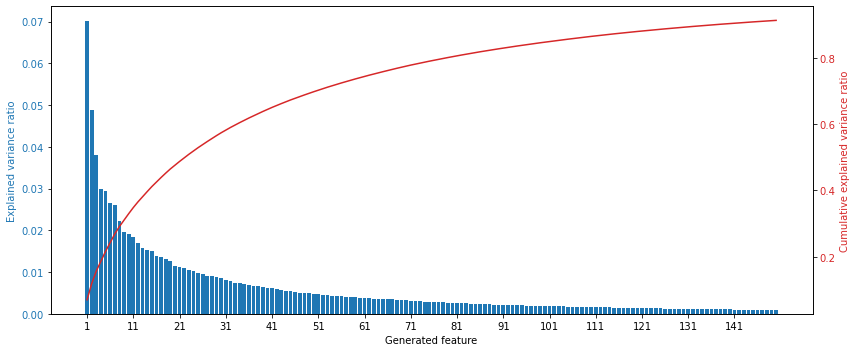

In [10]:
# code taken from assigment 2

# fit the PCA
N = 150
pca = PCA(n_components=N)
X_train_reduced = pca.fit_transform(X_train)

# plot the explained variances
fig, ax1 = plt.subplots(figsize=(12, 5))
color = 'tab:blue'
ax1.bar(1+np.arange(N), pca.explained_variance_ratio_, color=color)
ax1.set_xticks(1+np.arange(N, step=10))
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylabel("Explained variance ratio", color=color)
ax1.set_xlabel("Generated feature")

ax2 = ax1.twinx()
color = 'tab:red'
ax2.tick_params(axis='y', labelcolor=color)
ax2.plot(1+np.arange(N), np.cumsum(pca.explained_variance_ratio_), color=color)
ax2.set_ylabel("Cumulative explained variance ratio", color=color)
fig.tight_layout()
plt.show()

In [11]:
N = 100
pca.set_params(n_components=N)
X_train_reduced = pca.fit_transform(X_train)

In [12]:
# taken from assignment 2
def generate_confusion_matrix(y_true, y_pred, ax=None, label=""):
    # visualize the confusion matrix
    if ax == None:
        ax = plt.subplot()
    c_mat = confusion_matrix(y_true, y_pred)
    sns.heatmap(c_mat, annot=True, fmt='g', ax=ax)

    ax.set_xlabel('Predicted labels', fontsize=15)
    ax.set_ylabel('True labels', fontsize=15)
    ax.set_title('Confusion Matrix ' + label, fontsize=15)

Train SVC model and evaluate its performance

In [13]:
clf = SVC()
clf.fit(X_train_reduced, y_train)

SVC()

In [14]:
X_train_t = tf.convert_to_tensor(X_train)
y_train_t = tf.convert_to_tensor(y_train)
X_val_t = tf.convert_to_tensor(X_val)
y_val_t = tf.convert_to_tensor(y_val)

X_train_t = tf.reshape(X_train_t, [X_train_t.shape[0],SquareSide,SquareSide,1])
X_val_t = tf.reshape(X_val_t, [X_val_t.shape[0],SquareSide,SquareSide,1])

X_train_t = X_train_t / 255
X_val_t = X_val_t / 255

2022-10-07 03:23:51.016241: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [15]:
tf.random.set_seed(2)
cnn = models.Sequential()
cnn.add(layers.Conv2D(9, (3, 3), activation='relu', input_shape=(32, 32, 1)))
cnn.add(layers.MaxPooling2D((2, 2)))
cnn.add(layers.Conv2D(64, (3, 3), activation='relu'))
cnn.add(layers.MaxPooling2D((2, 2)))
cnn.add(layers.Conv2D(64, (3, 3), activation='relu'))
cnn.add(layers.Flatten())
cnn.add(layers.Dense(64, activation='relu'))
cnn.add(layers.Dropout(0.2))
cnn.add(layers.Dense(4, activation='softmax'))

cnn.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

history = cnn.fit(X_train_t, y_train_t, epochs=13, 
                    validation_data=(X_val_t, y_val_t))

2022-10-07 03:23:51.203616: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/13
50/50 [==============================] - 2s 29ms/step - loss: 0.9566 - accuracy: 0.5950 - val_loss: 0.7811 - val_accuracy: 0.7150
Epoch 2/13
50/50 [==============================] - 1s 26ms/step - loss: 0.6671 - accuracy: 0.7462 - val_loss: 0.5064 - val_accuracy: 0.8267
Epoch 3/13
50/50 [==============================] - 1s 26ms/step - loss: 0.4851 - accuracy: 0.8144 - val_loss: 0.4665 - val_accuracy: 0.8158
Epoch 4/13
50/50 [==============================] - 1s 26ms/step - loss: 0.3563 - accuracy: 0.8794 - val_loss: 0.3664 - val_accuracy: 0.8792
Epoch 5/13
50/50 [==============================] - 1s 26ms/step - loss: 0.2767 - accuracy: 0.9025 - val_loss: 0.2560 - val_accuracy: 0.9100
Epoch 6/13
50/50 [==============================] - 1s 27ms/step - loss: 0.2246 - accuracy: 0.9294 - val_loss: 0.2210 - val_accuracy: 0.9300
Epoch 7/13
50/50 [==============================] - 1s 26ms/step - loss: 0.1948 - accuracy: 0.9350 - val_loss: 0.2401 - val_accuracy: 0.9258
Epoch 8/13
50

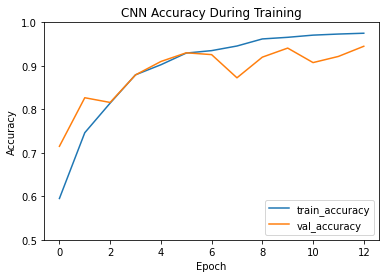

In [16]:
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('CNN Accuracy During Training')
plt.ylim([0.5, 1])
plt.legend(loc='lower right');

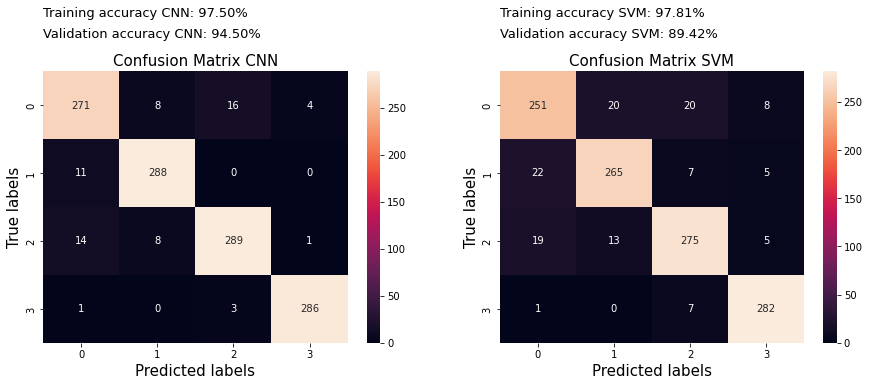

In [17]:
plt.rcParams['figure.figsize'] = [15, 5]

y_pred_cnn = tf.argmax(cnn.predict(X_val_t), axis=1)
accuracy_cnn = history.history['val_accuracy'][-1]
training_accuracy_cnn = history.history['accuracy'][-1]
ax = plt.subplot(1,2,1)
generate_confusion_matrix(y_val_t, y_pred_cnn, ax, 'CNN')
ax.text(0,-0.5, f"Validation accuracy CNN: {100*accuracy_cnn:.2f}% ", fontsize=13) 
ax.text(0,-0.8, f"Training accuracy CNN: {100*training_accuracy_cnn:.2f}% ", fontsize=13) 

y_pred_svm = clf.predict(pca.transform(X_val))
accuracy_svm = accuracy_score(y_val, y_pred_svm)
training_accuracy_svm = accuracy_score(y_train, clf.predict(pca.transform(X_train)))
ax = plt.subplot(1,2,2)
generate_confusion_matrix(y_val, y_pred_svm, ax, 'SVM')
ax.text(0, -0.5, f"Validation accuracy SVM: {100*accuracy_svm:.2f}%", fontsize=13)
ax.text(0, -0.8, f"Training accuracy SVM: {100*training_accuracy_svm:.2f}%", fontsize=13)
plt.rcParams['figure.figsize'] = [7.5, 5]

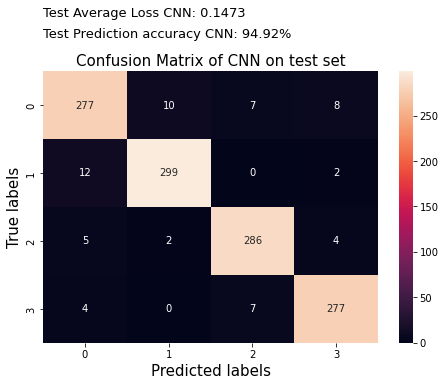

In [18]:
X_test_t = tf.convert_to_tensor(X_test)
y_test_t = tf.convert_to_tensor(y_test)
X_test_t = tf.reshape(X_test_t, [X_test_t.shape[0],SquareSide,SquareSide,1])
X_test_t = X_test_t / 255

y_pred_test_cnn = tf.argmax(cnn.predict(X_test_t), axis=1)

accuracy_test = accuracy_score(y_test_t, y_pred_test_cnn)
generate_confusion_matrix(y_test_t, y_pred_test_cnn, label='of CNN on test set')
test_average_loss = cnn.evaluate(X_test_t, y_test_t, verbose=0)[0]
plt.text(0,-0.5, f"Test Prediction accuracy CNN: {100*accuracy_test:.2f}%", fontsize=13)
plt.text(0,-0.8, f"Test Average Loss CNN: {test_average_loss:.4f}", fontsize=13);